In [3]:
import mysql.connector as dbCon
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import datetime
from pickle import dump
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def combineData():
    os.chdir("./SalesData")
    extension = 'csv'
    filenames = [i for i in glob.glob('*.{}'.format(extension))]
    #combine all files in the list
    combinedSales = pd.concat([pd.read_csv(f) for f in filenames ])
    #export to csv
    combinedSales.to_csv( "combinedSales.csv", index=False, encoding='utf-8-sig')

#combineData()

In [4]:
def loadData():
    data = pd.read_csv('./SalesData/combinedSales.csv', parse_dates=True)
    return data

salesData = loadData()

#data preprocessing through removal of empty rows
#and impractical columns, and converting datetime formats
salesData = salesData.dropna()
salesData = salesData[salesData['Order ID'].str.contains("Order ID") == False]
salesData = salesData.drop(['Purchase Address', 'Order ID'], axis=1)
salesData['Order Date'] = pd.to_datetime(salesData['Order Date'], errors='coerce').dt.date
salesData['Quantity Ordered'] = pd.to_numeric(salesData['Quantity Ordered'])
salesData["Price Each"] = salesData['Price Each'].str.replace(' ', '').astype(float)

In [5]:
#Generating insert statements for products

conn = dbCon.connect(host="localhost", user="root", password="cqX*5gk6^hvNFPvE", database="dsp")
dbCursor = conn.cursor()

def populateProducts():
    allProducts = salesData['Product'].unique()
    insertSQL = 'INSERT INTO products (ProdName, RetailPrice, SupplierPrice) VALUES (%s, %s, %s)'
    for product in allProducts:
        tempRetPrice = salesData[salesData['Product'] == product]['Price Each'].unique()[0]
        insParam = (product, tempRetPrice, round(tempRetPrice * 0.8, 2))
        dbCursor.execute(insertSQL, insParam)

#populateProducts();       
conn.commit()
dbCursor.close()

#Creating product dictionary
dictCursor = conn.cursor()
dictSQL = 'SELECT ProdID, ProdName FROM products'
dictCursor.execute(dictSQL)
tempDict = dictCursor.fetchall()
prodDict = {}
for result in tempDict:
    prodDict[result[1]] = result[0]

dictCursor.close()
conn.close()
prodDict

{'20in Monitor': 110,
 '27in 4K Gaming Monitor': 103,
 '27in FHD Monitor': 109,
 '34in Ultrawide Monitor': 115,
 'AA Batteries (4-pack)': 104,
 'AAA Batteries (4-pack)': 106,
 'Apple Airpods Headphones': 105,
 'Bose SoundSport Headphones': 98,
 'Flatscreen TV': 108,
 'Google Phone': 99,
 'iPhone': 107,
 'LG Dryer': 111,
 'LG Washing Machine': 114,
 'Lightning Charging Cable': 102,
 'Macbook Pro Laptop': 101,
 'ThinkPad Laptop': 112,
 'USB-C Charging Cable': 97,
 'Vareebadd Phone': 113,
 'Wired Headphones': 100}

In [6]:
salesData

,Product,Quantity Ordered,Price Each,Order Date
0,USB-C Charging Cable,2,11.95,2019-04-19
2,Bose SoundSport Headphones,1,99.99,2019-04-07
3,Google Phone,1,600.00,2019-04-12
4,Wired Headphones,1,11.99,2019-04-12
5,Wired Headphones,1,11.99,2019-04-30
...,...,...,...,...
373695,AAA Batteries (4-pack),3,2.99,2019-09-17
373696,iPhone,1,700.00,2019-09-01
373697,iPhone,1,700.00,2019-09-23
373698,34in Ultrawide Monitor,1,379.99,2019-09-19


In [7]:
salesDb = salesData.groupby(['Order Date','Product']).agg({'Quantity Ordered':'sum','Price Each':pd.Series.mode}).reset_index()
salesDb

,Order Date,Product,Quantity Ordered,Price Each
0,2019-01-01,20in Monitor,8,109.99
1,2019-01-01,27in 4K Gaming Monitor,14,389.99
2,2019-01-01,27in FHD Monitor,16,149.99
3,2019-01-01,34in Ultrawide Monitor,36,379.99
4,2019-01-01,AA Batteries (4-pack),66,3.84
...,...,...,...,...
6822,2020-01-01,ThinkPad Laptop,4,999.99
6823,2020-01-01,USB-C Charging Cable,8,11.95
6824,2020-01-01,Vareebadd Phone,2,400.00
6825,2020-01-01,Wired Headphones,8,11.99


In [8]:
#Replacing product names with their IDs in salesDB
salesDb = salesDb.replace({'Product': prodDict})
salesDb

,Order Date,Product,Quantity Ordered,Price Each
0,2019-01-01,110,8,109.99
1,2019-01-01,103,14,389.99
2,2019-01-01,109,16,149.99
3,2019-01-01,115,36,379.99
4,2019-01-01,104,66,3.84
...,...,...,...,...
6822,2020-01-01,112,4,999.99
6823,2020-01-01,97,8,11.95
6824,2020-01-01,113,2,400.00
6825,2020-01-01,100,8,11.99


In [9]:
conn = dbCon.connect(host="localhost", user="root", password="cqX*5gk6^hvNFPvE", database="dsp")
dbCursor = conn.cursor()

salesSQL = 'INSERT INTO sales (DayT, ProductID, Quantity) VALUES (%s, %s, %s)'
def populateSales():
    for row in range(salesDb.shape[0]):
        dayVar = salesDb.iloc[row]['Order Date'].strftime('%Y-%m-%d')
        prodVar = salesDb.iloc[row]['Product'].item()
        quant = salesDb.iloc[row]['Quantity Ordered'].item()
        insVar = (dayVar, prodVar, quant)
        dbCursor.execute(salesSQL, insVar)
        
#populateSales()
conn.commit()
dbCursor.close()
conn.close()

In [10]:
salesDb

,Order Date,Product,Quantity Ordered,Price Each
0,2019-01-01,110,8,109.99
1,2019-01-01,103,14,389.99
2,2019-01-01,109,16,149.99
3,2019-01-01,115,36,379.99
4,2019-01-01,104,66,3.84
...,...,...,...,...
6822,2020-01-01,112,4,999.99
6823,2020-01-01,97,8,11.95
6824,2020-01-01,113,2,400.00
6825,2020-01-01,100,8,11.99


In [11]:
#Creating input and output dataframes
xSalesDF = salesDb[['Product']]
xSalesDF['WeekDay'] = pd.to_datetime(salesDb['Order Date']).dt.dayofweek
xSalesDF['MonthDay'] = pd.to_datetime(salesDb['Order Date']).dt.day
xSalesDF['Price'] = salesDb['Price Each']

from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
scalerY = StandardScaler()
X = scalerX.fit_transform(xSalesDF)

ySalesDF = salesDb[['Quantity Ordered']]
Y = scalerY.fit_transform(ySalesDF) # ySalesDF.to_numpy()  

from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, train_size=0.80, random_state=1)

C:\Users\Peter\AppData\Local\Temp\ipykernel_16396\861498423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xSalesDF['WeekDay'] = pd.to_datetime(salesDb['Order Date']).dt.dayofweek
C:\Users\Peter\AppData\Local\Temp\ipykernel_16396\861498423.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xSalesDF['MonthDay'] = pd.to_datetime(salesDb['Order Date']).dt.day


In [12]:
#Multilayer Perceptron (Back Propagation Neural Network)
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=(10,10), solver='sgd', learning_rate='constant', learning_rate_init=0.0005, activation='tanh', max_iter = 1000)
nn.fit(xTrain, yTrain)
networkScore = round(nn.score(xTest, yTest) * 100, 2)
print(mean_squared_error(yTest, nn.predict(xTest)))

C:\Users\Peter\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2087932964407928


In [13]:
#Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
dTree = DecisionTreeRegressor(random_state=0)
dTree.fit(xTrain, yTrain)
treeScore = round(dTree.score(xTest, yTest) * 100, 2)

In [14]:
#Linear Regression
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(xTrain, yTrain)
linearScore = round(linReg.score(xTest, yTest) * 100, 2)

In [15]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=0)
forest.fit(xTrain, yTrain)
forestScore = round(forest.score(xTest, yTest) * 100, 2)

C:\Users\Peter\AppData\Local\Temp\ipykernel_16396\1317116163.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(xTrain, yTrain)


In [16]:
scoreDF = pd.DataFrame({'Model': ['MLP', 'Decision Tree', 'Linear Regression', 'Random Forest'],
                       'Accuracy': [networkScore, treeScore, linearScore, forestScore]})

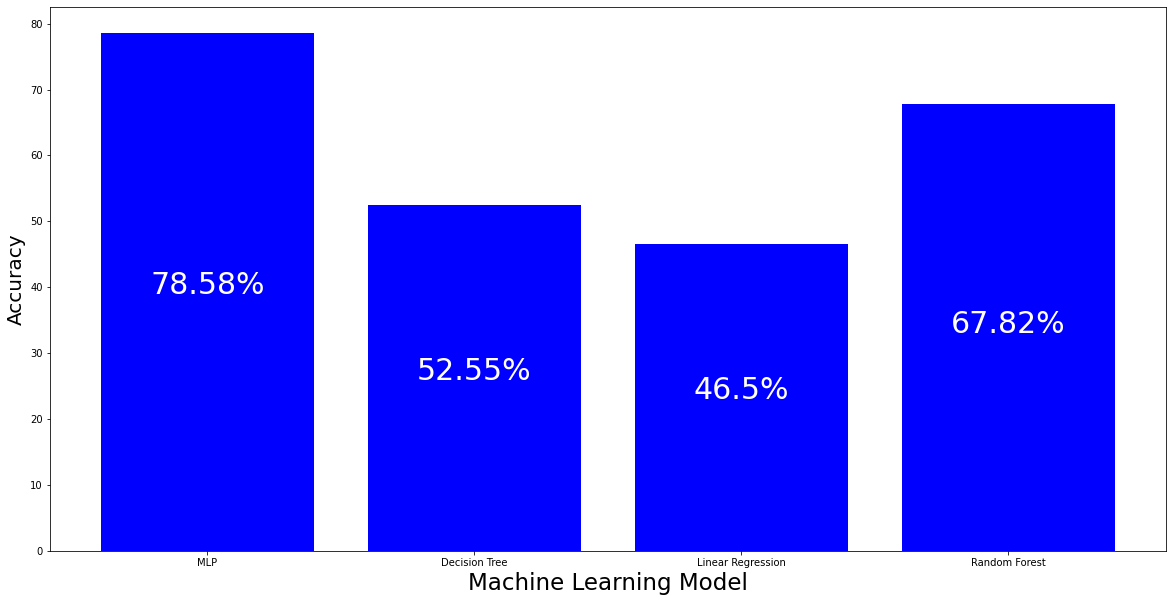

In [17]:
plt.figure(figsize = (20,10))
plt.bar(scoreDF['Model'], height = scoreDF['Accuracy'], color = 'blue')
plt.xlabel('Machine Learning Model', fontsize = 23)
plt.ylabel('Accuracy', fontsize = 20)
x = scoreDF['Model']
y = scoreDF['Accuracy']
for i in range(len(x)):
    temp = str(y[i])
    temp = temp + '%'
    plt.text(i, y[i]//2, temp, ha = 'center', color = 'white',fontsize = 30)
plt.show()

In [18]:
#dump(nn, open('model.pkl','wb'))
# dump(scalerX, open('scalerX.pkl', 'wb'))
#dump(scalerY, open('scalerY.pkl', 'wb'))

In [19]:
pred = nn.predict(xTest)
print(pred.shape)
pred = pred.reshape(-1,1)
scalerY.inverse_transform(pred)

(1366,)


array([[32.28913923],
       [20.72640186],
       [87.0943455 ],
       ...,
       [26.3491626 ],
       [12.64993322],
       [40.70449538]])

In [20]:
scalerY.inverse_transform(yTest)

array([[ 14.],
       [ 24.],
       [122.],
       ...,
       [ 24.],
       [  8.],
       [ 12.]])